<a href="https://colab.research.google.com/github/venkatesh-eranti/Clustering_Project_online-retail_case-study/blob/main/clustering_online_retail_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement:
For an [UK based non-store online retail](https://archive.ics.uci.edu/ml/datasets/online+retail) for which we need to cluster it's customers in to different groups so that we can run targeted campaign for each group

# Reading and understanding the data

## importing the necessary librariers

In [ ]:
# reading and processing the data
import numpy as np
import pandas as pd
# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
# rescalling the data
from sklearn.preprocessing import StandardScaler
# clustering the data
from sklearn.cluster import KMeans
# silhouette_score
from sklearn.metrics import silhouette_score

## loading the data from repository

In [ ]:
link='https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

Attribute information:
* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
df=pd.read_excel(link)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## understanding the data

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# clean the data

## Handling the missing values

### percentaege of missing values

In [ ]:
100*round(df.isnull().sum()/len(df),4)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

general rule is dropping missing values if the percentage of missing values are less than 1% and if missing values are more we need to drop the entrire column.But as this is customer segmentation study we can not drop the customer id column instead we need to drop the missing rows

### dropping all the missing values

In [ ]:
df=df.dropna()
df.shape

(406829, 8)

# preparation of data for modeling

creating a useful metric `price/ amount` to get total order value

In [ ]:
df['amount']=df['Quantity']*df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## RFM analysis for Customer Segmentation
[RFM Analysis](https://clevertap.com/blog/rfm-analysis/): RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

- R (Recency): Number of days since last purchase
- F (Frequency): Number of transactions over a period 
- M (Monetary): Total amount of transactions (revenue contributed)

### preparing Monetary feature

In [ ]:
monetary_df=df.groupby('CustomerID')['amount'].sum()
monetary_df=monetary_df.reset_index()
monetary_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


showing 0.00 as amount?

In [ ]:
df[df['CustomerID']==12346.0	]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6


customer ordered and then cancelled the order so it is zero

### preparing Frequency feature

In [ ]:
frequency_df=df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
frequency_df=frequency_df.rename(columns={'InvoiceNo':'frequency'})
frequency_df.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### preparing recency feature
Number of days since last purchase

In [ ]:
recency_df=df.copy()
recency_df['date_diff']=df['InvoiceDate'].max()-df['InvoiceDate']
recency_df=recency_df.groupby('CustomerID')['date_diff'].min().reset_index()

In [ ]:
recency_df=recency_df.rename(columns={'date_diff':'recency'})
recency_df.head()

,CustomerID,recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


### merging all RFM features in to single DataFrame

In [ ]:
rfm_df=pd.merge(pd.merge(monetary_df,frequency_df),recency_df)

In [ ]:
rfm_df['recency']=rfm_df['recency'].dt.days
rfm_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## outlier detection


In [ ]:
import warnings
warnings.filterwarnings('ignore')

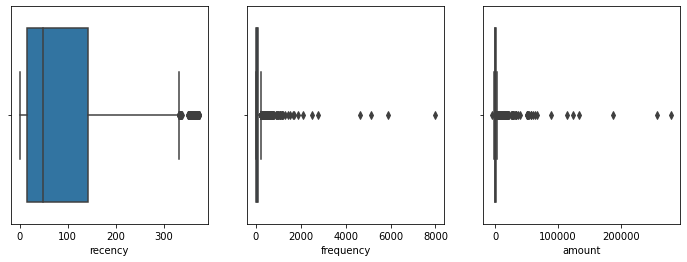

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(12,4));
sns.boxplot(rfm_df['recency'],ax=axs[0]);
sns.boxplot(rfm_df['frequency'],ax=axs[1]);
sns.boxplot(rfm_df['amount'],ax=axs[2]);

In [ ]:
import warnings
warnings.resetwarnings()

### observations from boxplots:
in **statistical** sense i can see there are many outliers in all 3 features but in **business** sense i may need these ouliers to increase my business or take some corrective action for the customers who are not recent visitors. or may be give some exceptional discounts for valued customer who spends more money(outliers are a good opportunity to lean a new trends or something that even retailers might not know).<br>
but for this study i am going to remove ouliers which are 1.5 S.D away from mean.


In [ ]:
rfm_df.head(2)

,CustomerID,amount,frequency,recency
0,12346.0,0.0,2,325
1,12347.0,4310.0,182,1


In [ ]:
rfm_df.shape

(4372, 4)

In [ ]:
Q1 = rfm_df.amount.quantile(0.05)
Q3 = rfm_df.amount.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.amount >= Q1 - 1.5*IQR) & (rfm_df.amount <= Q3 + 1.5*IQR)]

In [ ]:
Q1 = rfm_df.recency.quantile(0.05)
Q3 = rfm_df.recency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.recency >= Q1 - 1.5*IQR) & (rfm_df.recency <= Q3 + 1.5*IQR)]

In [ ]:
Q1 = rfm_df.frequency.quantile(0.05)
Q3 = rfm_df.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.frequency >= Q1 - 1.5*IQR) & (rfm_df.frequency <= Q3 + 1.5*IQR)]

In [ ]:
rfm_df.shape

(4293, 4)

## Rescaling the features
as clustering algorithm works by measuring distances so it is influenced by the data if they are in different scales

In [ ]:
scaler=StandardScaler()

In [ ]:
rfm_df_scaled=rfm_df.copy()

In [ ]:
rfm_df_scaled[rfm_df_scaled.columns.drop('CustomerID')]=scaler.fit_transform(rfm_df_scaled[rfm_df_scaled.columns.drop('CustomerID')])

In [ ]:
rfm_df_scaled=rfm_df_scaled.drop('CustomerID',axis=1)
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the **cluster tendency**, in other words: how well the data can be clustered.<br>

If the value is between {0.01, ...,0.3}, the data is regularly spaced.<br>

If the value is around 0.5, it is random.<br>

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n=X.shape[0]
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [ ]:
hopkins(rfm_df_scaled)

0.9526930713433144

# Modeling

## fitting the kmeans with some random number of clusters

In [ ]:
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([2, 3, 1, ..., 2, 1, 1], dtype=int32)

In [ ]:
kmeans.inertia_

3360.7191025770203

## Finding the number of optimal clusters

### elbow curve method (sum of squared distances)

Text(0, 0.5, 'cost function(SSD')

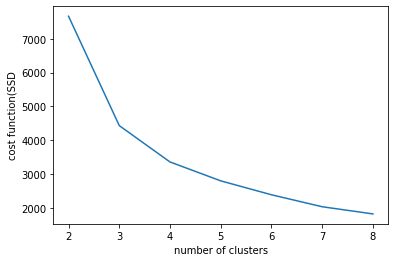

In [ ]:
elbow=[]
for i in range(2,9): #more than 8 clusters in business point of view is not promising
    kmeans=KMeans(n_clusters=i,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    elbow.append(kmeans.inertia_) 
sns.lineplot(y=elbow,x=range(2,9),markers=True) #plot the ssd of each cluster
plt.xlabel('number of clusters')
plt.ylabel('cost function(SSD')

as per elbow curve the rate of drop of SSD is significant at 3.<br>
(when we go from 2-3 clusters ssd drop is significant with more slope than from 3-4 as we keep on increase the clusters this will surely drop further but with less change of rate)

### silhouette score

silhouette_score=$\frac{b_i-a_i}{max(b_i,a_i)}$
* $a_i$ is the mean **intra-cluster** distance to all the points in its own cluster.
* $b_i$ is the mean **inter-cluster** distance to all the points in the nearest cluster that the data point is not a part of <br> 

The value of the silhouette score range lies between -1 to 1.
- A score closer to 1 indicates that the data point is very similar to other data points in the cluster
- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [ ]:
for i in range(2,9):
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(rfm_df_scaled)    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(i, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084901609598225
For n_clusters=4, the silhouette score is 0.47782241003860476
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41701094135102007
For n_clusters=7, the silhouette score is 0.41497171900778634
For n_clusters=8, the silhouette score is 0.4119167324764657


* obviously 2 clusters are not a good choice 
* but 3 sounds more natural in a business point of view.

## build final model

In [ ]:
kmeans=KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

# assigning labels to model

In [ ]:
rfm_df['labels']=kmeans.labels_

In [ ]:
rfm_df.head()

,CustomerID,amount,frequency,recency,labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


### checking how the dataset works now

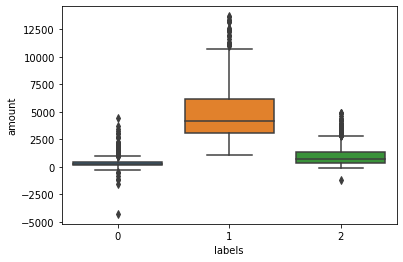

In [ ]:
sns.boxplot(y=rfm_df['amount'],x=rfm_df['labels'])

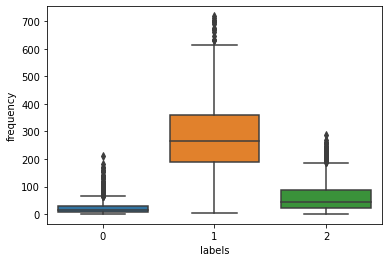

In [ ]:
sns.boxplot(y=rfm_df['frequency'],x=rfm_df['labels'])

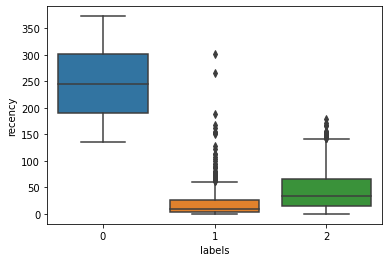

In [ ]:
sns.boxplot(y=rfm_df['recency'],x=rfm_df['labels'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


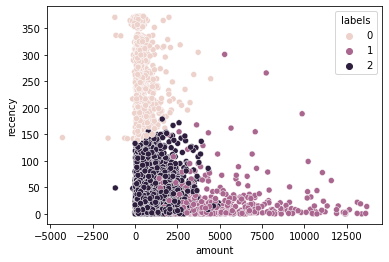

In [ ]:
sns.scatterplot(rfm_df['amount'],rfm_df['recency'],hue=rfm_df['labels'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


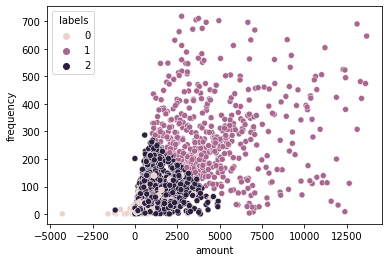

In [ ]:
sns.scatterplot(rfm_df['amount'],rfm_df['frequency'],hue=rfm_df['labels'])